Load all images from `input/`, rescaling to max 500x500px and converting to grayscale.

In [1]:
%pylab inline
from IPython.display import Image, display
import PIL.Image
import matplotlib.image as mpimg
import scipy.ndimage
import cv2 # For Sobel etc
import glob
np.set_printoptions(suppress=True, linewidth=200) # Better printing of arrays
plt.rcParams['image.cmap'] = 'jet' # Default colormap is jet

Populating the interactive namespace from numpy and matplotlib


In [2]:
filenames = glob.glob('input/*')
print(len(filenames))

2


In [3]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

# hSize = 20
# wSize = 15
col = 4

def showImagesMatrix(image_arr, col=10, cmap_='Greys_r', wSize=15, hSize=20):
    fig = figure( figsize=(wSize, hSize))
    n = len(image_arr)
    row = n/col
    if (n%col != 0):
        row += 1
    for i in range(n):
        a=fig.add_subplot(row,col,i+1)
        image = image_arr[i]
        imshow(image, cmap=cmap_)
        axis('off')

/Users/rohiJoon/opt/anaconda3/envs/py3.7env/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  from ipykernel import kernelapp as app


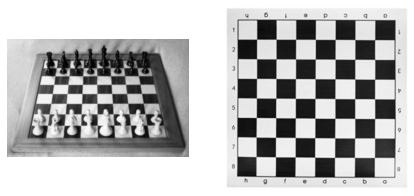

In [4]:
# Load all images (after rescaling and grayscale)
img_arr = []
for i in range(len(filenames)):
    filename = filenames[i]

    img_orig = PIL.Image.open(filename)
    img_width, img_height = img_orig.size

    # Resize
    aspect_ratio = min(500.0/img_width, 500.0/img_height)
    new_width, new_height = ((np.array(img_orig.size) * aspect_ratio)).astype(int)
    img = img_orig.resize((new_width,new_height), resample=PIL.Image.BILINEAR)
    img = img.convert('L') # grayscale
    img = np.array(img)
    img = cv2.blur(img, (3,3)) # Blur it
    img_arr.append(img)

showImagesMatrix(img_arr,col)

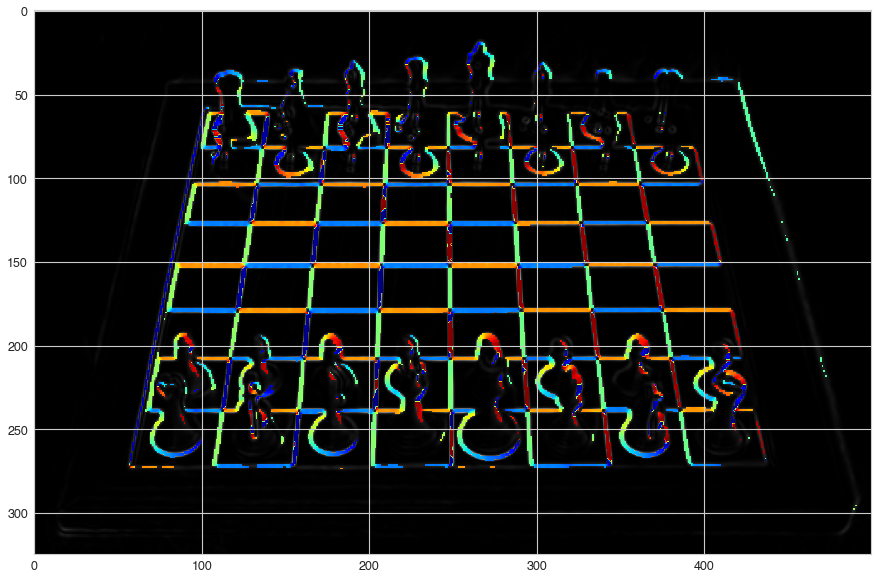

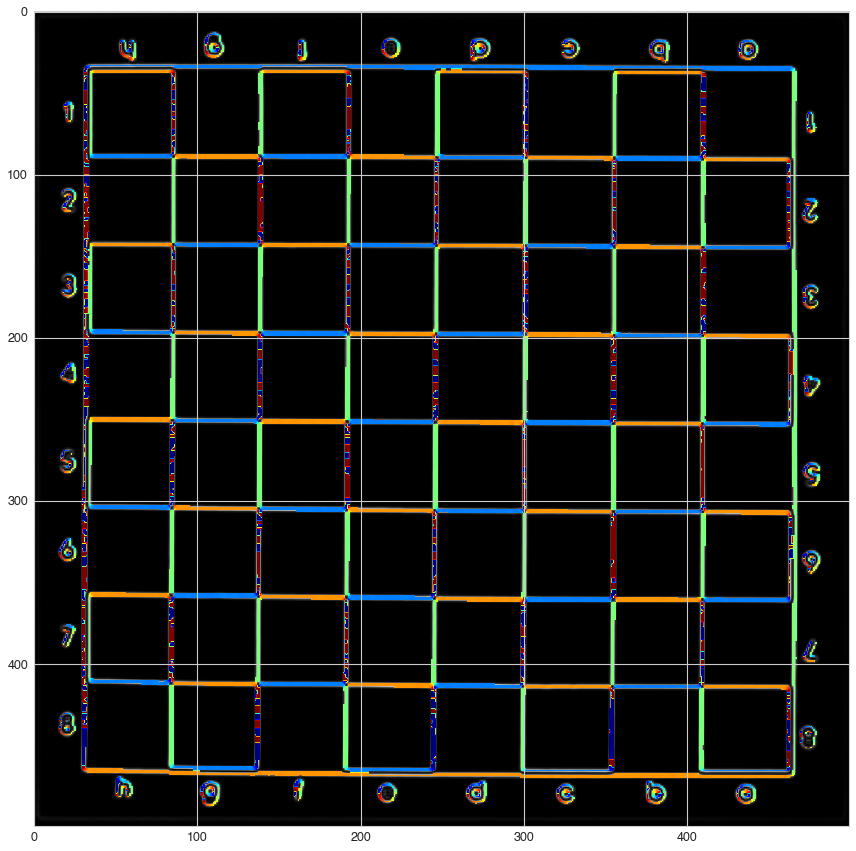

In [5]:
grad_mags = []
grad_phases = []

for img in img_arr:
#     img = img_arr[20]

    gx = cv2.Sobel(img,cv2.CV_64F,1,0)
    gy = cv2.Sobel(img,cv2.CV_64F,0,1)

    grad_mag = gx*gx+gy*gy
    grad_phase = np.arctan2(gy, gx) # from -pi to pi
    grad_phase_masked = grad_phase.copy()
    gradient_mask_threshold = 2*np.mean(grad_mag.flatten())
    grad_phase_masked[grad_mag < gradient_mask_threshold] = np.nan

    figure( figsize=(15, 15))
    imshow(grad_mag, cmap='Greys_r')
    imshow(grad_phase_masked)
    grad_mags.append(grad_mag)
    grad_phases.append(grad_phase_masked)
    

/Users/rohiJoon/opt/anaconda3/envs/py3.7env/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  from ipykernel import kernelapp as app


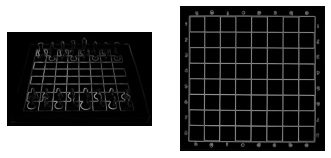

In [6]:
showImagesMatrix(grad_mags, col=5, cmap_='Greys_r')

/Users/rohiJoon/opt/anaconda3/envs/py3.7env/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  from ipykernel import kernelapp as app


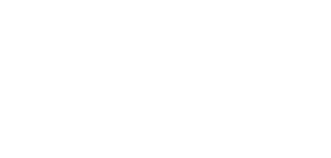

In [7]:
showImagesMatrix(grad_phases, col=5, cmap_='jet')

Saddle detect http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.87.5833&rep=rep1&type=pdf 

In [8]:
def getSaddle(gray_img):
    img = gray_img.astype(np.float64)
    gx = cv2.Sobel(img,cv2.CV_64F,1,0)
    gy = cv2.Sobel(img,cv2.CV_64F,0,1)
    gxx = cv2.Sobel(gx,cv2.CV_64F,1,0)
    gyy = cv2.Sobel(gy,cv2.CV_64F,0,1)
    gxy = cv2.Sobel(gx,cv2.CV_64F,0,1)
    
    S = gxx*gyy - gxy**2
    return S

In [9]:
def nonmax_sup(img, win=10):
    w, h = img.shape
#     img = cv2.blur(img, ksize=(5,5))
    img_sup = np.zeros_like(img, dtype=np.float64)
    for i,j in np.argwhere(img):
        # Get neigborhood
        ta=max(0,i-win)
        tb=min(w,i+win+1)
        tc=max(0,j-win)
        td=min(h,j+win+1)
        cell = img[ta:tb,tc:td]
        val = img[i,j]
        if np.sum(cell.max() == cell) > 1:
            print(cell.argmax())
        if cell.max() == val:
            img_sup[i,j] = val
    return img_sup

In [10]:
# i = 5
# s = saddles[i].copy()
# s2 = nonmax_sup(s)
# print(np.sum(s2!=0))
# pts = np.argwhere(s2!=0)
# # print(pts)

# figure(figsize=(20,20))
# plt.grid()
# imshow(img_arr[i], cmap='Greys_r', interpolation='None')
# plt.plot(pts[:,1], pts[:,0], 'o')


In [11]:
def pruneSaddle(s):
    thresh = 128
    score = (s>0).sum()
    while (score > 10000):
        thresh = thresh*2
        s[s<thresh] = 0
        score = (s>0).sum()

In [12]:
saddle

NameError: name 'saddle' is not defined

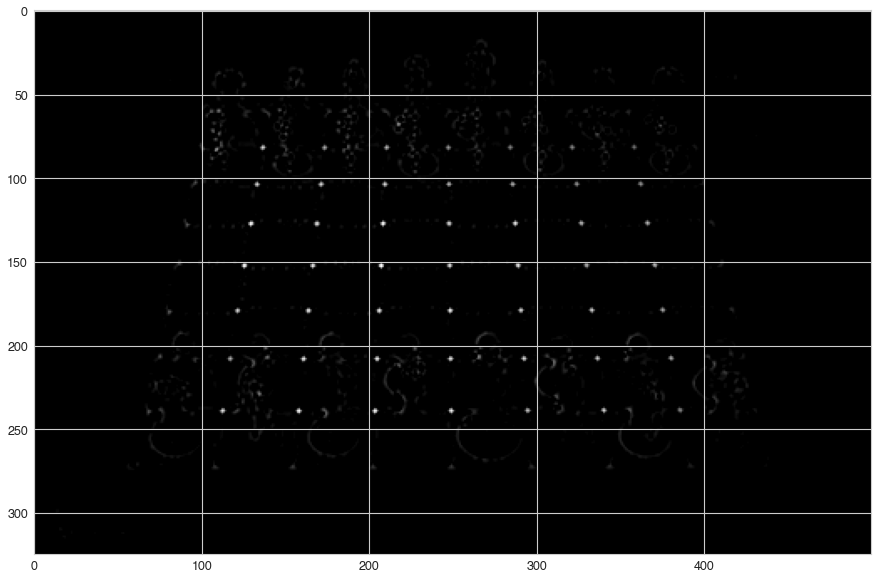

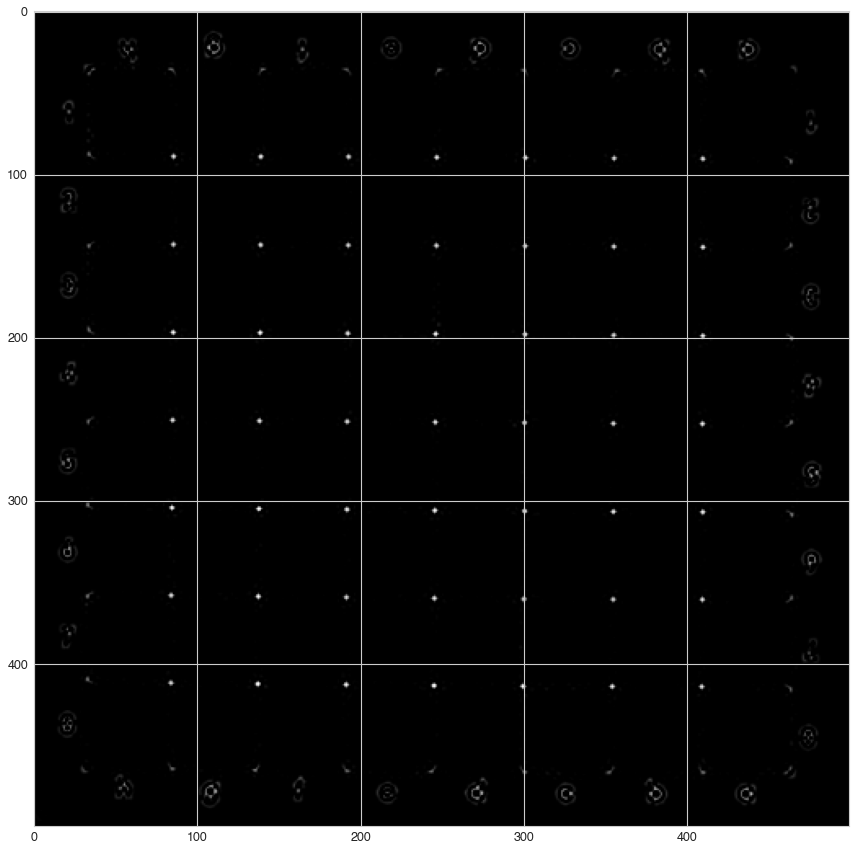

In [14]:
saddles = []
for img in img_arr:
#     img = img_arr[20]

    saddle = getSaddle(img)
    saddle = -saddle
    saddle[saddle<0] = 0
    
    pruneSaddle(saddle)

    saddles.append(saddle)
    figure( figsize=(15, 15))
    imshow(saddle, cmap='Greys_r')
#     imshow(grad_phase_masked)


/Users/rohiJoon/opt/anaconda3/envs/py3.7env/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  from ipykernel import kernelapp as app


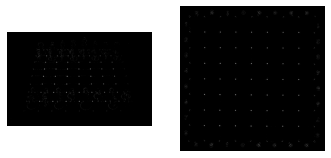

In [15]:
showImagesMatrix(saddles, col=5)

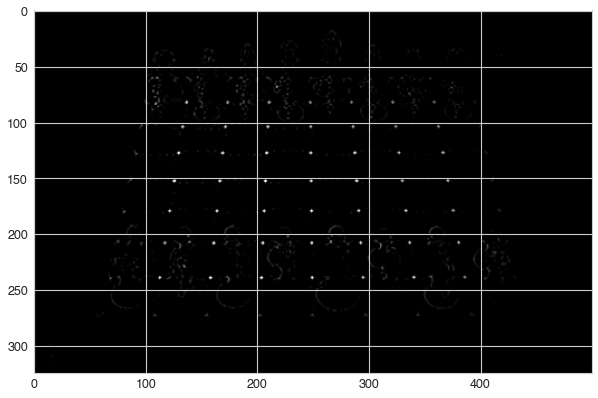

In [16]:
s = saddles[0].copy()
   
plt.figure(figsize=(10,10))
imshow(s,  cmap='Greys_r')
# plt.hist(s[:])

In [17]:
def simplifyContours(contours):
  for i in range(len(contours)):
    # Approximate contour and update in place
    contours[i] = cv2.approxPolyDP(contours[i],0.04*cv2.arcLength(contours[i],True),True)

def is_square(cnt, eps=3.0, xratio_thresh = 0.5):
  # 4x2 array, rows are each point, columns are x and y
  center = cnt.sum(axis=0)/4

  # Side lengths of rectangular contour
  dd0 = np.sqrt(((cnt[0,:] - cnt[1,:])**2).sum())
  dd1 = np.sqrt(((cnt[1,:] - cnt[2,:])**2).sum())
  dd2 = np.sqrt(((cnt[2,:] - cnt[3,:])**2).sum())
  dd3 = np.sqrt(((cnt[3,:] - cnt[0,:])**2).sum())

  # diagonal ratio
  xa = np.sqrt(((cnt[0,:] - cnt[2,:])**2).sum())
  xb = np.sqrt(((cnt[1,:] - cnt[3,:])**2).sum())
  xratio = xa/xb if xa < xb else xb/xa

  # Check whether all points part of convex hull
  # ie. not this http://i.stack.imgur.com/I6yJY.png
  # all corner angles, angles are less than 180 deg, so not necessarily internal angles
  ta = getAngle(dd3, dd0, xb) 
  tb = getAngle(dd0, dd1, xa)
  tc = getAngle(dd1, dd2, xb)
  td = getAngle(dd2, dd3, xa)
  angle_sum = np.round(ta+tb+tc+td)

  is_convex = np.abs(angle_sum - 360) < 5

  angles = np.array([ta,tb,tc,td])
  good_angles = np.all((angles > 40) & (angles < 140))


  # side ratios
  dda = dd0 / dd1
  if dda < 1:
    dda = 1. / dda
  ddb = dd1 / dd2
  if ddb < 1:
    ddb = 1. / ddb
  ddc = dd2 / dd3
  if ddc < 1:
    ddc = 1. / ddc
  ddd = dd3 / dd0
  if ddd < 1:
    ddd = 1. / ddd
  side_ratios = np.array([dda,ddb,ddc,ddd])
  good_side_ratios = np.all(side_ratios < eps)

  # Return whether side ratios within certain ratio < epsilon
  return (
    # abs(1.0 - dda) < eps and 
    # abs(1.0 - ddb) < eps and
    # xratio > xratio_thresh and 
    # good_side_ratios and
    # is_convex and
    good_angles)
    
def getAngle(a,b,c):
  # Get angle given 3 side lengths, in degrees
  k = (a*a+b*b-c*c) / (2*a*b)
  # Handle floating point errors
  if (k < -1):
    k=-1
  elif k > 1:
    k=1
  return np.arccos(k) * 180.0 / np.pi

def getContourVals(cnt, img):
    cimg = np.zeros_like(img)
    cv2.drawContours(cimg, [cnt], 0, color=255, thickness=-1)
    return img[cimg!=0]

def pruneContours(contours, hierarchy, saddle):
  new_contours = []
  new_hierarchies = []
  for i in range(len(contours)):
    cnt = contours[i]
    h = hierarchy[i]
    
    # Must be child
    if h[2] != -1:
        continue
    
    # Only rectangular contours allowed
    if len(cnt) != 4:
      continue
        
    # Only contours that fill an area of at least 8x8 pixels
    if cv2.contourArea(cnt) < 8*8:
      continue

    if not is_square(cnt):
      continue
    
    # TODO : Remove those where internal luma variance is greater than threshold
    
    cnt = updateCorners(cnt, saddle)
    # If not all saddle corners
    if len(cnt) != 4:
        continue

    new_contours.append(cnt)
    new_hierarchies.append(h)
  new_contours = np.array(new_contours)
  new_hierarchy = np.array(new_hierarchies)
  if len(new_contours) == 0:
    return new_contours, new_hierarchy
  
#   norm_contours = new_contours[:,:,0,:] - new_contours[:,[0],0,:]
#   median_contour = np.median(norm_contours, axis=0).astype(int)
#   diff = np.sqrt(np.sum((norm_contours - median_contour)**2,axis=2))

#   mask=np.all(diff < 60, axis=1)
# #   print(mask.shape)
#   new_contours = new_contours[mask]
#   new_hierarchy = new_hierarchy[mask]

  # Prune contours below median area
  areas = [cv2.contourArea(c) for c in new_contours]
  mask = [areas >= np.median(areas)*0.25] and [areas <= np.median(areas)*2.0]
  new_contours = new_contours[mask]
  new_hierarchy = new_hierarchy[mask]
  return np.array(new_contours), np.array(new_hierarchy)


In [18]:
def getContours(img, edges, iters=10):
    # Morphological Gradient to get internal squares of canny edges. 
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    edges_gradient = cv2.morphologyEx(edges, cv2.MORPH_GRADIENT, kernel)
    contours, hierarchy = cv2.findContours(edges_gradient, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    
    simplifyContours(contours)  
    
    return np.array(contours), hierarchy[0]


/Users/rohiJoon/opt/anaconda3/envs/py3.7env/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/Users/rohiJoon/opt/anaconda3/envs/py3.7env/lib/python3.7/site-packages/ipykernel_launcher.py:124: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/rohiJoon/opt/anaconda3/envs/py3.7env/lib/python3.7/site-packages/ipykernel_launcher.py:125: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the 

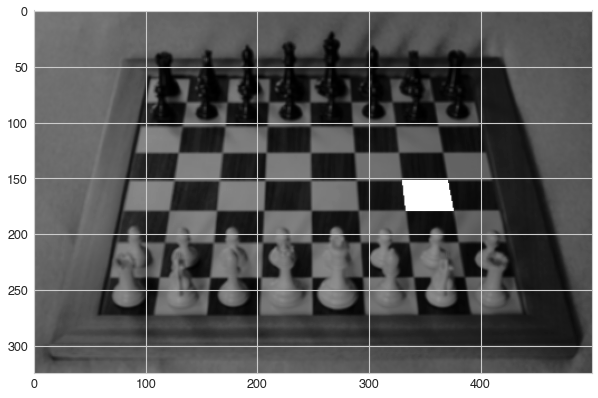

In [19]:
def updateCorners(contour, saddle):
#     print(contour)
    ws = 4 # half window size (+1)
    new_contour = contour.copy()
    for i in range(len(contour)):
#         print(i, contour[i,0,:])
        cc,rr = contour[i,0,:]
        rl = max(0,rr-ws)
        cl = max(0,cc-ws)
        window = saddle[rl:min(saddle.shape[0],rr+ws+1),cl:min(saddle.shape[1],cc+ws+1)]
#         window = saddle[rr-ws:rr+ws+1,cc-ws:cc+ws+1]
#         print(window.astype(np.int)/1000)
        br, bc = np.unravel_index(window.argmax(), window.shape)
        s_score = window[br,bc]
        br -= min(ws,rl)
        bc -= min(ws,cl)
#         print(s_score, br, bc)
        if s_score > 0:
            new_contour[i,0,:] = cc+bc,rr+br
        else:
#             print("no saddle")
            return []
    return new_contour
        

img = img_arr[0].copy()
s = saddles[0]
edges = cv2.Canny(img, 20, 250)

contours_all, hierarchy = getContours(img,edges)

contours, hierarchy = pruneContours(contours_all, hierarchy, s)

c = contours[2]
c2 = updateCorners(c, s)
# print(c2)

plt.figure(figsize=(10,10))
img = img / 2
# cv2.drawContours(img,[c],-1,155,-1) # Fill mask with 1's inside contour
# img[saddle!=0] /= 2
cv2.drawContours(img,[c2],-1,255,-1) # Fill mask with 1's inside contour
imshow(img, cmap='Greys_r');

[[[299 414]]

 [[354 414]]

 [[352 467]]

 [[300 466]]]


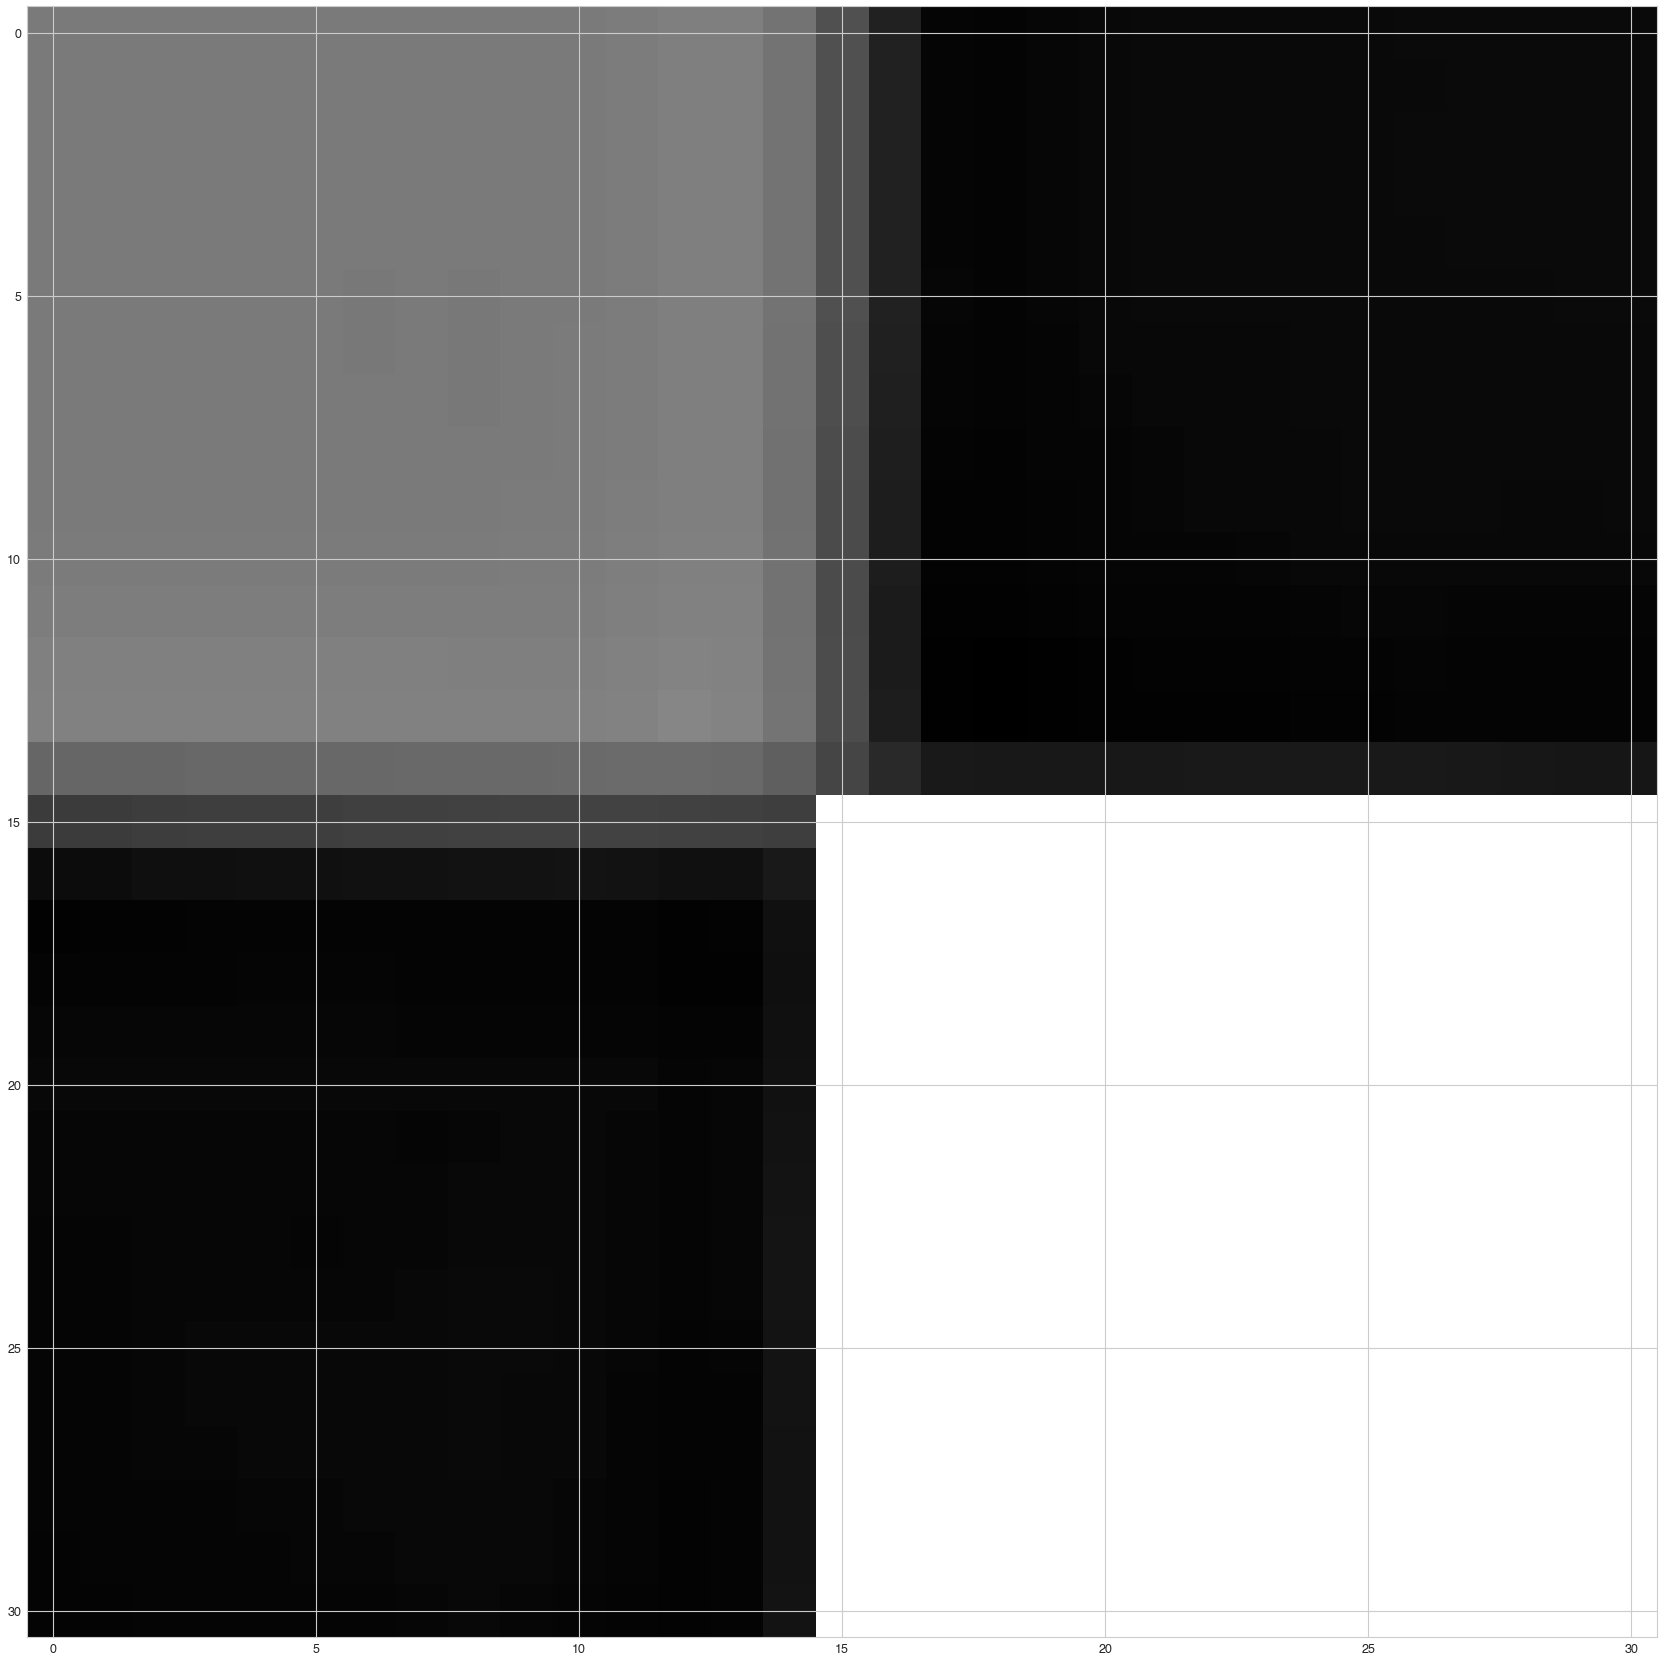

In [65]:
print(c)
cc,rr = c[0,0,:]
plt.figure(figsize=(30,30))
imshow(img[rr-15:rr+16,cc-15:cc+16], cmap='Greys_r');

/Users/rohiJoon/opt/anaconda3/envs/py3.7env/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/Users/rohiJoon/opt/anaconda3/envs/py3.7env/lib/python3.7/site-packages/ipykernel_launcher.py:124: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/rohiJoon/opt/anaconda3/envs/py3.7env/lib/python3.7/site-packages/ipykernel_launcher.py:125: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the 

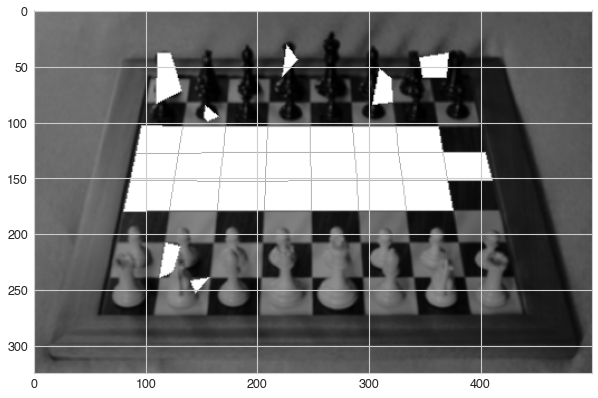

In [20]:
img = img_arr[0].copy()
s = saddles[0]
edges = cv2.Canny(img, 20, 250)



contours_all, hierarchy = getContours(img,edges)

contours, hierarchy = pruneContours(contours_all, hierarchy, s)
# print(contours.shape)
# print(contours.tolist())
plt.figure(figsize=(10,10))
img = img / 2
# cv2.drawContours(img,contours_all,-1,150,3) # Fill mask with 1's inside contour
cv2.drawContours(img,contours,-1,255,-1) # Fill mask with 1's inside contour
cv2.drawContours(img,contours,-1,150,0) # Fill mask with 1's inside contour
# for i in range(len(contours)):
#     cv2.putText(img, '%d' % i, (contours[i,0,0,0], contours[i,0,0,1]-6), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 255)
imshow(img, cmap='Greys_r');

/Users/rohiJoon/opt/anaconda3/envs/py3.7env/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/Users/rohiJoon/opt/anaconda3/envs/py3.7env/lib/python3.7/site-packages/ipykernel_launcher.py:124: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/rohiJoon/opt/anaconda3/envs/py3.7env/lib/python3.7/site-packages/ipykernel_launcher.py:125: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the 

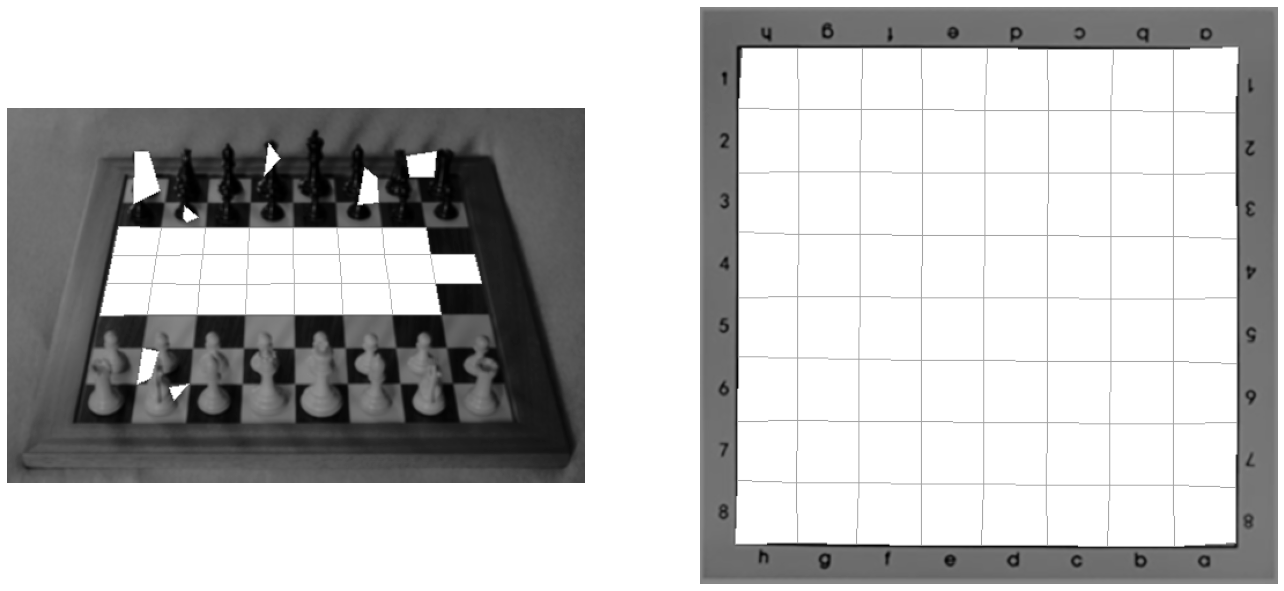

In [21]:
annotated_imgs = []
for i, img in enumerate(img_arr):
    edges = cv2.Canny(img, 20, 250)
    s = saddles[i]

    contours_all, hierarchy = getContours(img,edges)
    contours, hierarchy = pruneContours(contours_all, hierarchy, s)

    img = img / 2
    cv2.drawContours(img,contours,-1,255,-1) # Fill mask with 1's inside contour
    cv2.drawContours(img,contours,-1,150,0) # Outline
    annotated_imgs.append(img)

showImagesMatrix(annotated_imgs, col=5, wSize=60, hSize=80)

/Users/rohiJoon/opt/anaconda3/envs/py3.7env/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/Users/rohiJoon/opt/anaconda3/envs/py3.7env/lib/python3.7/site-packages/ipykernel_launcher.py:124: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/rohiJoon/opt/anaconda3/envs/py3.7env/lib/python3.7/site-packages/ipykernel_launcher.py:125: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the 

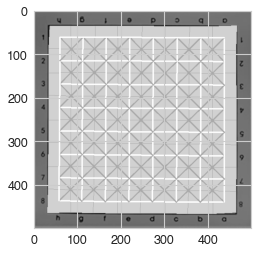

In [23]:
adj_arr = []
for iii in range(len(img_arr)):
#     i = 3
    img=img_arr[iii].copy()
#     plt.figure(figsize=(10,10))

    edges = cv2.Canny(img, 20, 250)
    s = saddles[iii]

    contours_all, hierarchy = getContours(img,edges)
    contours, hierarchy = pruneContours(contours_all, hierarchy, s)


    cnts = contours.squeeze().copy()

    N = len(cnts)
    adj_mtx = np.zeros([N,N],dtype=np.int)

    matches = {}
    for i in range(N):
        for k in range(4):
            pt = cnts[i,k,:]
            key = "%d_%d" % (pt[0],pt[1])
            if key in matches.keys():
                matches[key].append(i)
            else:
                matches[key] = [i]
    #         matches[] 

    # print(matches.values())

    for adj_set in matches.values():
        if len(adj_set) > 1:
    #         print(adj_set)
            for i in range(len(adj_set)-1):
                for j in range(i+1,len(adj_set)):
                    adj_mtx[adj_set[i],adj_set[j]] += 1


    # View
    img = img / 2
    cv2.drawContours(img,contours,-1,190,-1) # Fill mask with 1's inside contour
    cv2.drawContours(img,contours,-1,150,0) # Outline

    for i,j in np.argwhere(adj_mtx):
    #     print(i,j, adj_mtx[i,j])
        cnt_a = contours[i]
        cnt_b = contours[j]
        cnt_a_ctr = cnt_a[:,0,:].sum(axis=0) // 4
        cnt_b_ctr = cnt_b[:,0,:].sum(axis=0) // 4
        line_str = 55 + adj_mtx[i,j] * 100

        cv2.line(img, tuple(cnt_a_ctr), tuple(cnt_b_ctr), (int(line_str), int(line_str),int(line_str)),2)
    
    adj_arr.append(img)




    imshow(img, cmap='Greys_r');

/Users/rohiJoon/opt/anaconda3/envs/py3.7env/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  from ipykernel import kernelapp as app


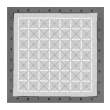

In [93]:
showImagesMatrix(adj_arr, col=5, wSize=10, hSize=10)

/Users/rohiJoon/opt/anaconda3/envs/py3.7env/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/Users/rohiJoon/opt/anaconda3/envs/py3.7env/lib/python3.7/site-packages/ipykernel_launcher.py:124: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/rohiJoon/opt/anaconda3/envs/py3.7env/lib/python3.7/site-packages/ipykernel_launcher.py:125: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the 

[[140 242]
 [157 239]
 [144 253]
 [140 242]]


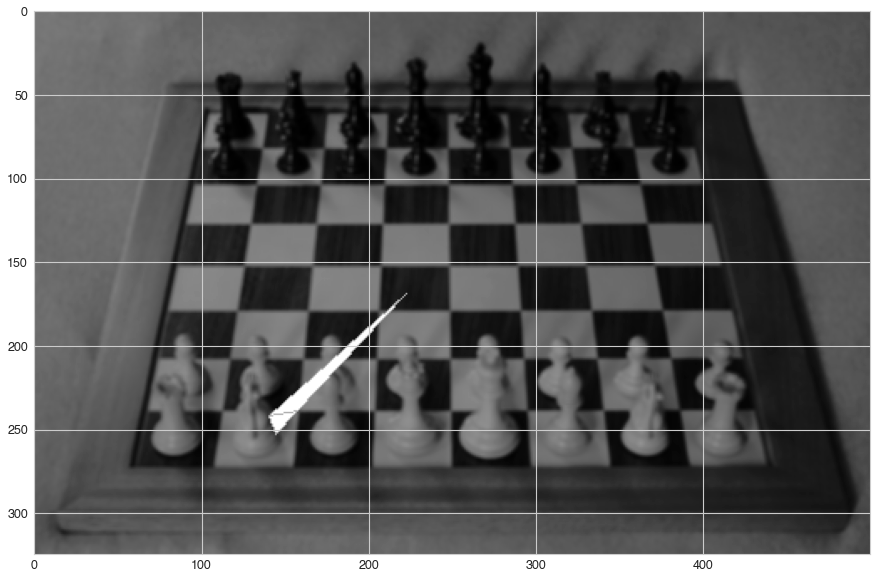

In [24]:
img = img_arr[0].copy()
s = saddles[0]
edges = cv2.Canny(img, 20, 250)



contours_all, hierarchy = getContours(img,edges)

contours, hierarchy = pruneContours(contours_all, hierarchy, s)
# print(contours.shape)
# print(contours.tolist())
img = img / 2

cnt_i = 0

cnt = contours[cnt_i].squeeze()
print(cnt)
da = cnt[1,:]-cnt[0,:]
db = cnt[2,:]-cnt[1,:]
dc = cnt[3,:]-cnt[2,:]
dd = cnt[0,:]-cnt[3,:]
# cnt += -db*3
cnt2 = cnt.copy()
cnt2[3,:] = cnt[0,:]
cnt2[2,:] = cnt[1,:]
cnt2[0,:] = cnt[0,:] + dd*5
cnt2[1,:] = cnt[1,:] - db*5

cv2.drawContours(img,[cnt],-1,255,-1) # Fill mask with 1's inside contour
cv2.drawContours(img,[cnt],-1,150,0) # Fill mask with 1's inside contour

cv2.drawContours(img,[cnt2],-1,255,-1) # Fill mask with 1's inside contour
cv2.drawContours(img,[cnt2],-1,150,0) # Fill mask with 1's inside contour

plt.figure(figsize=(20,10))
imshow(img, cmap='Greys_r');

/Users/rohiJoon/opt/anaconda3/envs/py3.7env/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/Users/rohiJoon/opt/anaconda3/envs/py3.7env/lib/python3.7/site-packages/ipykernel_launcher.py:124: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/rohiJoon/opt/anaconda3/envs/py3.7env/lib/python3.7/site-packages/ipykernel_launcher.py:125: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the 

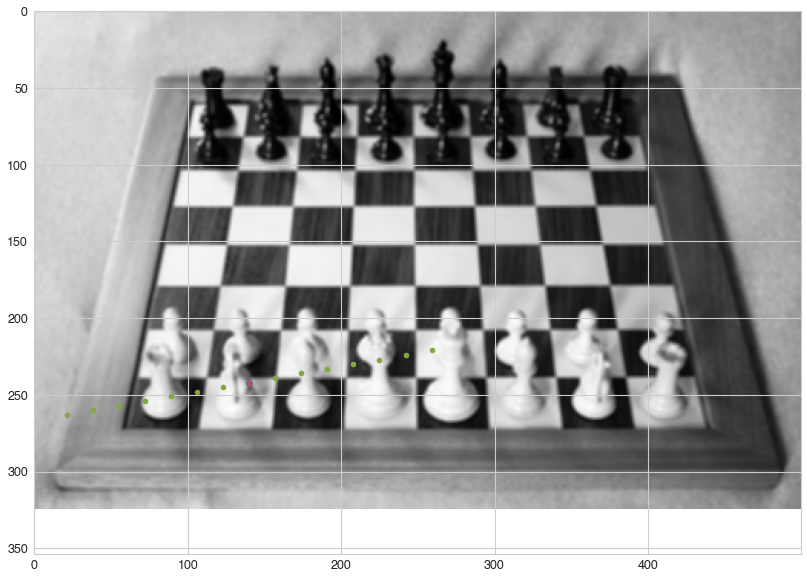

In [25]:
img = img_arr[0].copy()
s = saddles[0]
edges = cv2.Canny(img, 20, 250)



contours_all, hierarchy = getContours(img,edges)

contours, hierarchy = pruneContours(contours_all, hierarchy, s)
# print(contours.shape)
# print(contours.tolist())
img = img / 2

cnt_i = 0

cnt = contours[cnt_i].squeeze()
# print(cnt)
da = cnt[1,:]-cnt[0,:]
db = cnt[2,:]-cnt[1,:]
dc = cnt[3,:]-cnt[2,:]
dd = cnt[0,:]-cnt[3,:]

# 0 da 1
# dd   db
# 3 dc 2

p0 = cnt[0,:]
p1 = cnt[1,:]
p2 = cnt[2,:]
p3 = cnt[3,:]
pA = np.matrix(p0).T + np.matrix(da).T * np.arange(-7,8) # horz 1
pA2 = np.matrix(p3).T + np.matrix(dc).T * np.arange(-7,8) # horz 2

# vert
pB = np.matrix(p0).T + np.matrix(dd).T * np.arange(-7,8)
pB2 = np.matrix(p1).T + np.matrix(db).T * np.arange(-7,8)
# cnt += -db*3
# cnt2 = cnt.copy()
# cnt2[3,:] = cnt[0,:]
# cnt2[2,:] = cnt[1,:]
# cnt2[0,:] = cnt[0,:] + dd*5
# cnt2[1,:] = cnt[1,:] - db*5

plt.figure(figsize=(20,10))
imshow(img, cmap='Greys_r');
plt.plot(pA[0,:].A, pA[1,:].A, 'og')
plt.plot(pA2[0,:].A, pA2[1,:].A, 'xg')
plt.plot(pB[0,:].A, pB[1,:].A, 'ob')
plt.plot(pB2[0,:].A, pB2[1,:].A, 'xb')
plt.plot(p0[0], p0[1], 'or');

[370 152] [370 152] 0.0


(-0.5, 499.5, 324.5, -0.5)

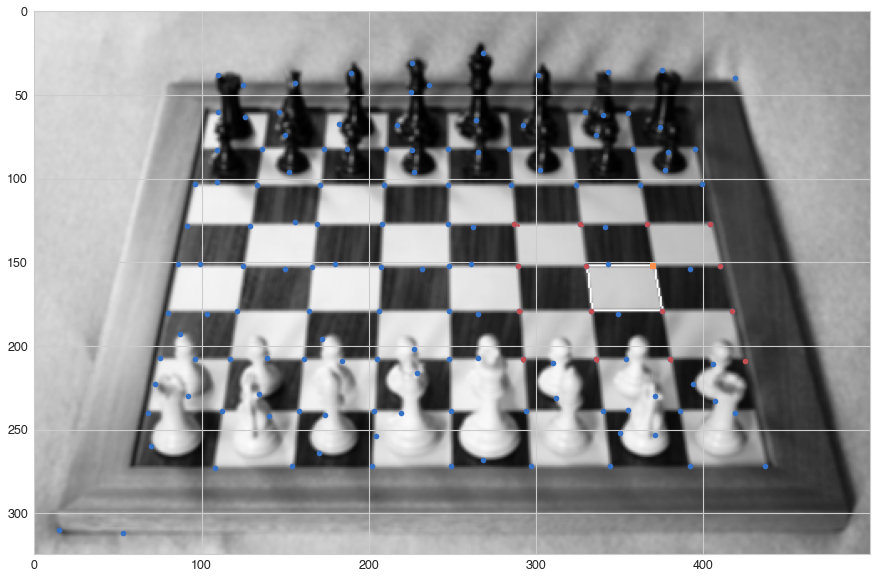

In [26]:
def getIdentityGrid(N):
    a = np.arange(N)
    b = a.copy()
    aa,bb = np.meshgrid(a,b)
    return np.vstack([aa.flatten(), bb.flatten()]).T

def getChessGrid(quad):
    quadA = np.array([[0,1],[1,1],[1,0],[0,0]],dtype=np.float32)
    M = cv2.getPerspectiveTransform(quadA, quad.astype(np.float32))
    quadB = getIdentityGrid(4)-1
    quadB_pad = np.pad(quadB, ((0,0),(0,1)), 'constant', constant_values=1)
    C_thing = (np.matrix(M)*quadB_pad.T).T
#     bad = (C_thing[:,2] < 0.3).A.flatten()
    C_thing[:,:2] /= C_thing[:,2]
    return C_thing

img_i = 0
img = img_arr[img_i].copy()
s = saddles[img_i]

cnt_i = 2
cnt = contours[cnt_i].squeeze()

s2 = nonmax_sup(s)
s2[s2<100000]=0
spts = np.argwhere(s2)
def getMinSaddleDist(saddle_pts, pt):
    best_dist = None
    best_pt = pt
    for saddle_pt in saddle_pts:
        saddle_pt = saddle_pt[::-1]
        dist = np.sum((saddle_pt - pt)**2)
        if best_dist is None or dist < best_dist:
            best_dist = dist
            best_pt = saddle_pt
    return best_pt, np.sqrt(best_dist)
# print(s2[spts[:,0],spts[:,1]].min())


warp_grid = getChessGrid(cnt)
warp_grid_fix = warp_grid.copy()
for pt_i in range(len(warp_grid_fix)):
    pt2, d = getMinSaddleDist(spts, warp_grid_fix[pt_i,:2].A.flatten())
    if (d < 5): # px
        warp_grid_fix[pt_i,:2] = pt2


plt.figure(figsize=(20,10))
img_over = img.copy()
cv2.drawContours(img_over,[cnt],-1,255,0) # Fill mask with 1's inside contour
imshow(img_over, cmap='Greys_r');
axs = plt.axis()
plt.plot(spts[:,1],spts[:,0],'o')
plt.plot(warp_grid[:,0].A, warp_grid[:,1].A,'r.')
plt.plot(warp_grid_fix[:,0].A, warp_grid_fix[:,1].A,'ro')

kA = cnt[1,:]
kB, d = getMinSaddleDist(spts, cnt[1,:])
print(kA, kB, d)
# plt.plot(kA[0], kA[1],'ys')
plt.plot([kA[0],kB[0]], [kA[1],kB[1]],'ys-')

plt.axis(axs)

# vals = getContourVals(cnt, img)
# print(np.std(vals))
# print(spts == [214,308])
# print(spts)

Start with quad, get perspective transform M, take points for 3x3 quad around it, keep only those where a saddle is within N pixels. 
Redo M transform with new set of good points, rinse repeat till we have a full 9x9 grid.

In [27]:
def findGoodPoints(grid, spts, max_px_dist=5):
    # Snap grid points to closest saddle point within range and return updated
    # grid = Nx2 points on grid
    new_grid = grid.copy()
    chosen_spts = set()
    N = len(new_grid)
    grid_good = np.zeros(N,dtype=np.bool)
    hash_pt = lambda pt: "%d_%d" % (pt[0], pt[1])
    
    for pt_i in range(N):
        pt2, d = getMinSaddleDist(spts, grid[pt_i,:2].A.flatten())
        if hash_pt(pt2) in chosen_spts:
            d = max_px_dist
        else:
            chosen_spts.add(hash_pt(pt2))
        if (d < max_px_dist): # max dist to replace with
            new_grid[pt_i,:2] = pt2
            grid_good[pt_i] = True
    return new_grid, grid_good

def getInitChessGrid(quad):
    quadA = np.array([[0,1],[1,1],[1,0],[0,0]],dtype=np.float32)
    M = cv2.getPerspectiveTransform(quadA, quad.astype(np.float32))
    return makeChessGrid(M,1)

def makeChessGrid(M, N=1):
    ideal_grid = getIdentityGrid(2+2*N)-N
    ideal_grid_pad = np.pad(ideal_grid, ((0,0),(0,1)), 'constant', constant_values=1) # Add 1's column
    # warped_pts = M*pts
    grid = (np.matrix(M)*ideal_grid_pad.T).T
    grid[:,:2] /= grid[:,2] # normalize by t
    grid = grid[:,:2] # remove 3rd column
    return grid, ideal_grid, M

def generateNewBestFit(grid_ideal, grid, grid_good):
    a = np.float32(grid_ideal[grid_good])
    b = np.float32(grid[grid_good])
    M = cv2.findHomography(a, b, cv2.RANSAC)
    return M

/Users/rohiJoon/opt/anaconda3/envs/py3.7env/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/Users/rohiJoon/opt/anaconda3/envs/py3.7env/lib/python3.7/site-packages/ipykernel_launcher.py:124: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/rohiJoon/opt/anaconda3/envs/py3.7env/lib/python3.7/site-packages/ipykernel_launcher.py:125: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the 

On Contour 0
I 0 (N=1), num_good: 4 of 16
I 1 (N=2), num_good: 5 of 36
I 2 (N=3), num_good: 6 of 64
I 3 (N=4), num_good: 7 of 100
I 4 (N=5), num_good: 8 of 144
I 5 (N=6), num_good: 9 of 196
I 6 (N=7), num_good: 10 of 256
On Contour 1
I 0 (N=1), num_good: 6 of 16
I 1 (N=2), num_good: 7 of 36
I 2 (N=3), num_good: 8 of 64
I 3 (N=4), num_good: 10 of 100
I 4 (N=5), num_good: 13 of 144
I 5 (N=6), num_good: 13 of 196
I 6 (N=7), num_good: 14 of 256
On Contour 2
I 0 (N=1), num_good: 9 of 16
I 1 (N=2), num_good: 23 of 36
I 2 (N=3), num_good: 34 of 64
I 3 (N=4), num_good: 47 of 100
I 4 (N=5), num_good: 62 of 144
I 5 (N=6), num_good: 70 of 196
I 6 (N=7), num_good: 79 of 256


(-0.5, 499.5, 499.5, -0.5)

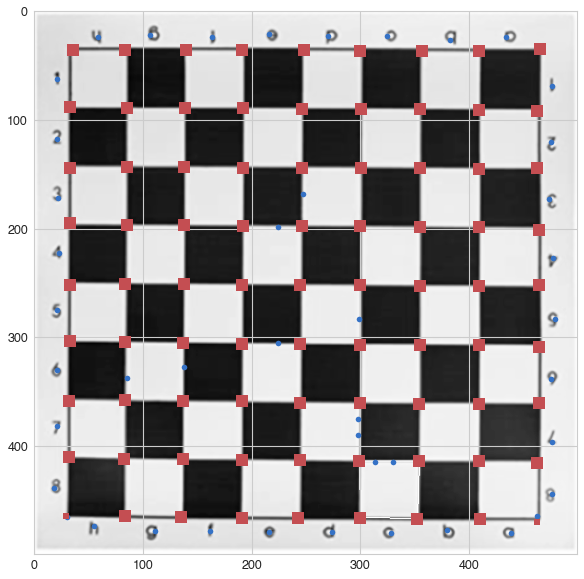

In [30]:
img_i = 1
img = img_arr[img_i].copy()
s = saddles[img_i]

edges = cv2.Canny(img, 20, 250)
contours_all, hierarchy = getContours(img,edges)
contours, hierarchy = pruneContours(contours_all, hierarchy, s)

for cnt_i in range(len(contours)):
    # cnt_i = 5
    print ("On Contour %d" % cnt_i)
    cnt = contours[cnt_i].squeeze()

    s2 = nonmax_sup(s)
    s2[s2<100000]=0
    spts = np.argwhere(s2)

    grid_curr, ideal_grid, M = getInitChessGrid(cnt)
    # print(M)

    for grid_i in range(7):
        grid_curr, ideal_grid, _ = makeChessGrid(M, N=(grid_i+1))
        grid_next, grid_good = findGoodPoints(grid_curr, spts)
        M, _ = generateNewBestFit(ideal_grid, grid_next, grid_good)
        print('I %d (N=%d), num_good: %d of %d' % (grid_i, grid_i+1, np.sum(grid_good), grid_good.size))
        if M is None:
            print ("Failed to converge on this one")
            break
    #     print(M2)
    if M is None:
        continue
    elif np.sum(grid_good) > 30:
        break

# View
plt.figure(figsize=(20,10))
img_over = img.copy()
cv2.drawContours(img_over,[cnt],-1,255,0) # Fill mask with 1's inside contour
imshow(img_over, cmap='Greys_r');
axs = plt.axis()
plt.plot(spts[:,1],spts[:,0],'o')
plt.plot(grid_next[:,0].A, grid_next[:,1].A,'rs')
plt.plot(grid_next[grid_good,0].A, grid_next[grid_good,1].A,'rs', markersize=12)

# plt.plot(grid_step2[:,0].A, grid_step2[:,1].A,'gs')

# plt.plot([kA[0],kB[0]], [kA[1],kB[1]],'ys-')
plt.axis(axs)

In [31]:
def getGrads(img):
    img = cv2.blur(img,(5,5))
    gx = cv2.Sobel(img,cv2.CV_64F,1,0)
    gy = cv2.Sobel(img,cv2.CV_64F,0,1)

    grad_mag = gx*gx+gy*gy
    grad_phase = np.arctan2(gy, gx) # from -pi to pi
    grad_phase_masked = grad_phase.copy()
    gradient_mask_threshold = 2*np.mean(grad_mag.flatten())
    grad_phase_masked[grad_mag < gradient_mask_threshold] = np.nan
    return grad_mag, grad_phase_masked, grad_phase, gx, gy

# grad_mag, grad_phase_masked, grad_phase, gx, gy = getGrads(img_warp)

def getBestLines(img_warped):
    grad_mag, grad_phase_masked, grad_phase, gx, gy = getGrads(img_warped)
    
    # X
    gx_pos = gx.copy()
    gx_pos[gx_pos < 0] = 0
    gx_neg = -gx.copy()
    gx_neg[gx_neg < 0] = 0
    score_x = np.sum(gx_pos, axis=0) * np.sum(gx_neg, axis=0)
    # Y
    gy_pos = gy.copy()
    gy_pos[gy_pos < 0] = 0
    gy_neg = -gy.copy()
    gy_neg[gy_neg < 0] = 0
    score_y = np.sum(gy_pos, axis=1) * np.sum(gy_neg, axis=1)
    
    # Choose best internal set of 7
    a = np.array([(offset + np.arange(7) + 1)*32 for offset in np.arange(1,11-2)])
    scores_x = np.array([np.sum(score_x[pts]) for pts in a])
    scores_y = np.array([np.sum(score_y[pts]) for pts in a])
    
    # 15x15 grid, so along an axis a set of 7, and an internal 7 at that, so 13x13 grid, 7x7 possibility inside
    # We're also using a 1-padded grid so 17x17 grid
    # We only want the internal choices (13-7) so 6x6 possible options in the 13x13 
    # so 2,3,4,5,6,7,8 to 8,9,10,11,12,13,14 ignoring 0,1 and 15,16,17
    best_lines_x = a[scores_x.argmax()]
    best_lines_y = a[scores_y.argmax()]
    return (best_lines_x, best_lines_y)

Now that we have matched an oversized grid to the chessboard, warp the image for that oversized grid. Then we know the chessboard is somewhere in the ~64 possible start positions. Convolve an ideal black/white grid with all 64 points (maybe an inverted one too) to get the best chessboard position. Better perhaps apply black/white and white/black grid to full grid to find orientation, then strip sides until you have the best internal 8, for both

/Users/rohiJoon/opt/anaconda3/envs/py3.7env/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/Users/rohiJoon/opt/anaconda3/envs/py3.7env/lib/python3.7/site-packages/ipykernel_launcher.py:124: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/rohiJoon/opt/anaconda3/envs/py3.7env/lib/python3.7/site-packages/ipykernel_launcher.py:125: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the 

[[ 42.06846122   8.50394222 121.61885866]
 [ -0.08249796 -21.34632208 179.14318493]
 [ -0.00035601   0.03566413   1.        ]]


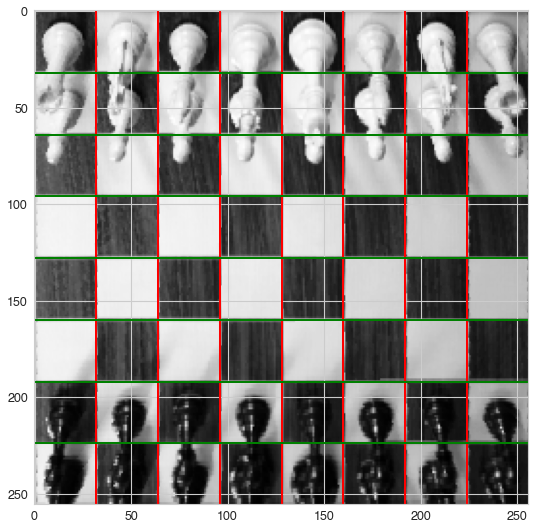

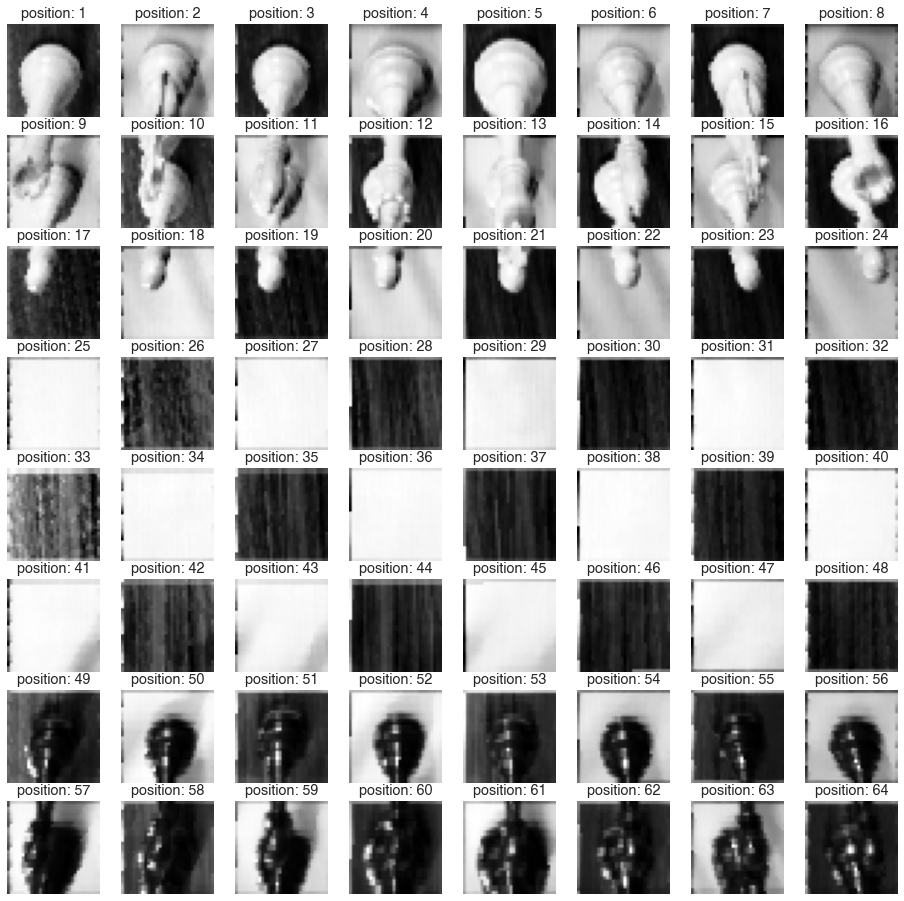

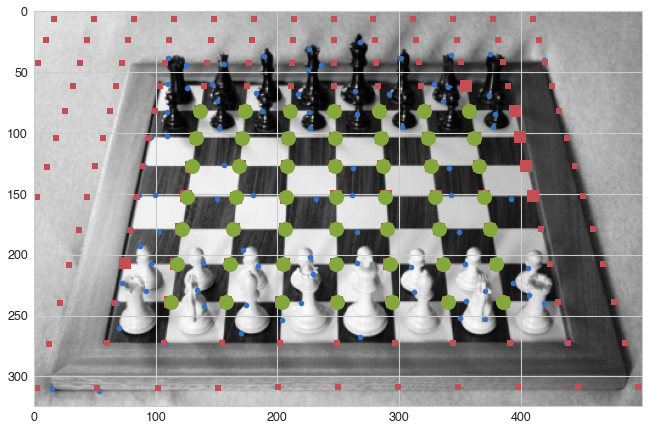

In [134]:
def getBoardOutlinewarped(best_lines_x, best_lines_y, M):
    d = best_lines_x[1] - best_lines_x[0]
    ax = [best_lines_x[0]-d, best_lines_x[-1]+d]
    ay = [best_lines_y[0]-d, best_lines_y[-1]+d]
    x,y = np.meshgrid(ax, ay)
    xy = np.vstack([x.flatten(), y.flatten()]).T.astype(np.float32)
    xy = xy[[0,1,3,2,0],:]
    xy = np.expand_dims(xy,0)

    return xy[0,:,:]

def loadImage(filepath):
    img_orig = PIL.Image.open(filepath)
    img_width, img_height = img_orig.size

    # Resize
    aspect_ratio = min(500.0/img_width, 500.0/img_height)
    new_width, new_height = ((np.array(img_orig.size) * aspect_ratio)).astype(int)
    img = img_orig.resize((new_width,new_height), resample=PIL.Image.BILINEAR)
    img = img.convert('L') # grayscale
    img = np.array(img)
    
    return img

def findChessboard(img, min_pts_needed=15, max_pts_needed=25):
    blur_img = cv2.blur(img, (3,3)) # Blur it
    saddle = getSaddle(blur_img)
    saddle = -saddle
    saddle[saddle<0] = 0
    pruneSaddle(saddle)
    s2 = nonmax_sup(saddle)
    s2[s2<100000]=0
    spts = np.argwhere(s2)

    edges = cv2.Canny(img, 20, 250)
    contours_all, hierarchy = getContours(img, edges)
    contours, hierarchy = pruneContours(contours_all, hierarchy, saddle)
    
    curr_num_good = 0
    curr_grid_next = None
    curr_grid_good = None
    curr_M = None

    for cnt_i in range(len(contours)):
        #print ("On Contour %d" % cnt_i)
        cnt = contours[cnt_i].squeeze()
        grid_curr, ideal_grid, M = getInitChessGrid(cnt)

        for grid_i in range(7):
            grid_curr, ideal_grid, _ = makeChessGrid(M, N=(grid_i+1))
            grid_next, grid_good = findGoodPoints(grid_curr, spts)
            num_good = np.sum(grid_good)
            #print('I %d (N=%d), num_good: %d of %d' % (grid_i, grid_i+1, num_good, grid_good.size))
            if num_good < 4:
                M = None
                #print ("Failed to converge on this one")
                break
            M, _ = generateNewBestFit(ideal_grid, grid_next, grid_good)
            # Check that a valid and reasonable M was returned
            if M is None or np.abs(M[0,0] / M[1,1]) > 15 or np.abs(M[1,1] / M[0,0]) > 15:
#             if M is None:
                M = None
                #print ("Failed to converge on this one")
                break
        if M is None:
            continue
        elif num_good > curr_num_good:
            curr_num_good = num_good
            curr_grid_next = grid_next
            curr_grid_good = grid_good
            curr_M = M

        # If we found something with more than max needed, good enough to stop here
        if num_good > max_pts_needed:
            break
            
    # If we found something
    if curr_num_good > min_pts_needed:
        final_ideal_grid = getIdentityGrid(2+2*7)-7
        return curr_M, final_ideal_grid, curr_grid_next, curr_grid_good, spts
    else:
        return None, None, None, None, None
#     return M, ideal_grid, grid_next, grid_good, spts

img = loadImage('input/sample1.jpeg')
M, ideal_grid, grid_next, grid_good, spts = findChessboard(img)
print(M)

# View
if M is not None:
    M, _ = generateNewBestFit((ideal_grid+8)*32, grid_next, grid_good) # generate mapping for warping image
#     print(M)
    img_warp = cv2.warpPerspective(img, M, (17*32, 17*32), flags=cv2.WARP_INVERSE_MAP)
    
    best_lines_x, best_lines_y = getBestLines(img_warp)
    xy_unwarp = getUnwarpedPoints(best_lines_x, best_lines_y, M)

    
    plt.figure(figsize=(20,20))
    plt.subplot(212)
    
    #Created the function getBoardOutlinewarped that would give the correct coordinates for the board border
    #in the wrapped setup, then will use that square bot to crop out the rest of the image and update
    #The coordinates of the the horizontal and vertical lines going thru the board , defining the cells
    #using the lines we finally use a double for loop to separate each cell into its own object, then 
    # We store it in a dictionary storing them using their positions as their key values ranging from 
    #1 to 64
    board_outline_unwarp = getBoardOutlinewarped(best_lines_x, best_lines_y, M)
    x_cord = []
    y_cord = []
    for pair in board_outline_unwarp[:4]:
        x_cord.append(pair[0])
        y_cord.append(pair[1])
        
    x1 = int(min(x_cord))
    y1 = int(min(y_cord))
    x2 = int(max(x_cord))
    y2 = int(max(y_cord))
    img_warp_cropped = img_warp[y1:y2, x1:x2]
    imshow(img_warp_cropped, cmap='Greys_r')
#     print(best_lines_x)
#     plt.plot(board_outline_unwarp[:,0] - x1, board_outline_unwarp[:,1] - y1, 'ro-', markersize=5, linewidth=3)
    [plt.axvline(line - x1, color='red', lw=2) for line in best_lines_x];
    [plt.axhline(line - y1, color='green', lw=2) for line in best_lines_y];
    fig = figure(figsize=(16, 16))
    
    best_lines_x = np.append(best_lines_x, [x2])
    best_lines_y = np.append(best_lines_y, [y2])
    checkerboard_cells = {}
    for i in range(len(best_lines_x)):
        vert_line = best_lines_x[i] - x1
        prev_vert_line = best_lines_x[i - 1] - x1 if i - 1 >= 0 else 0
        for j in range(len(best_lines_y)):
            horz_line = best_lines_y[j] - y1
            prev_horz_line = best_lines_y[j - 1] - y1 if j - 1 >= 0 else 0
            cell = img_warp_cropped[prev_horz_line:horz_line, prev_vert_line:vert_line]

            fig.add_subplot(8, 8, j * 8 + i + 1)
            plt.title("position: " + str(j * 8 + i + 1))
            plt.axis('off')
            checkerboard_cells[j * 8 + i + 1] = cell
            imshow(cell, cmap='Greys_r')
    
    
    figure(figsize=(16, 16))
    plt.subplot(211)
    axs = plt.axis()
    imshow(img, cmap='Greys_r');
    axs = plt.axis()
    plt.plot(spts[:,1],spts[:,0],'o')
    plt.plot(grid_next[:,0].A, grid_next[:,1].A,'rs')
    plt.plot(grid_next[grid_good,0].A, grid_next[grid_good,1].A,'rs', markersize=12)
    plt.plot(xy_unwarp[:,0], xy_unwarp[:,1], 'go', markersize=15)
    plt.axis(axs)

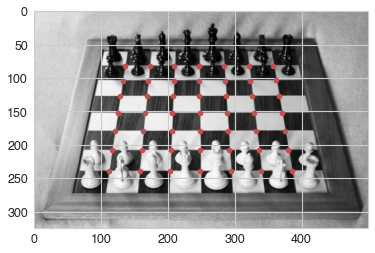

In [33]:
def getUnwarpedPoints(best_lines_x, best_lines_y, M):
    x,y = np.meshgrid(best_lines_x, best_lines_y)
    xy = np.vstack([x.flatten(), y.flatten()]).T.astype(np.float32)
    xy = np.expand_dims(xy,0)

    xy_unwarp = cv2.perspectiveTransform(xy, M)
    return xy_unwarp[0,:,:]
xy_unwarp = getUnwarpedPoints(best_lines_x, best_lines_y, M)
imshow(img, cmap='Greys_r');
axs = plt.axis()
plt.plot(xy_unwarp[:,0], xy_unwarp[:,1], 'ro')
plt.axis(axs);

In [124]:
# a = np.array([(offset + np.arange(7) + 1)*32 for offset in np.arange(2,11-3)])
# scores = np.array([np.sum(score_x[pts]) for pts in a])
# # 15x15 grid, so along an axis a set of 7, and an internal 7 at that, so 13x13 grid, 7x7 possibility inside
# # We're also using a 1-padded grid so 17x17 grid
# # We only want the internal choices (13-7) so 6x6 possible options in the 13x13 
# # so 3,4,5,6,7,8 to 9,10,11,12,13,14 ignoring 0,1,2 and 15,16,17
# best_lines = a[scores.argmax()]
# print(best_lines)
# plt.plot(score_x)
# for i in range(17):
#     plt.axvline(i*32, color='green')
# [plt.axvline(line, color='red') for line in best_lines]
# plt.xlim([0,544])

Idea 1 - Choose random tile, splay out all points, ICP to 9x9 with strongest saddle scores
Idea 2 - For all tiles, splay out all points, keep points that overlap within error and/or near saddle
Idea 3 - self-organizing map, use 9x9 grid of points with initial shape from random tile. The overall energy then is the deviation from this shape, for each saddle peak (randomly N times) pull closest point, pull other points elastically.
Idea 4 - Choose random tile, brute force all 9x9 grids, score each based on closest saddle per each (up to max), keep the min scoring one.

In [74]:
def getBoardOutline(best_lines_x, best_lines_y, M):
    d = best_lines_x[1] - best_lines_x[0]
    ax = [best_lines_x[0]-d, best_lines_x[-1]+d]
    ay = [best_lines_y[0]-d, best_lines_y[-1]+d]
    x,y = np.meshgrid(ax, ay)
    xy = np.vstack([x.flatten(), y.flatten()]).T.astype(np.float32)
    xy = xy[[0,1,3,2,0],:]
    xy = np.expand_dims(xy,0)

    xy_unwarp = cv2.perspectiveTransform(xy, M)
    return xy_unwarp[0,:,:]

def getBoardOutlinewarped(best_lines_x, best_lines_y, M):
    d = best_lines_x[1] - best_lines_x[0]
    ax = [best_lines_x[0]-d, best_lines_x[-1]+d]
    ay = [best_lines_y[0]-d, best_lines_y[-1]+d]
    x,y = np.meshgrid(ax, ay)
    xy = np.vstack([x.flatten(), y.flatten()]).T.astype(np.float32)
    xy = xy[[0,1,3,2,0],:]
    xy = np.expand_dims(xy,0)

    return xy[0,:,:]

Processing 1/2 : input/sample1.jpeg


/Users/rohiJoon/opt/anaconda3/envs/py3.7env/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/Users/rohiJoon/opt/anaconda3/envs/py3.7env/lib/python3.7/site-packages/ipykernel_launcher.py:124: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/rohiJoon/opt/anaconda3/envs/py3.7env/lib/python3.7/site-packages/ipykernel_launcher.py:125: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the 

[ 60.488888 438.6069   390.038    103.56539   60.488888]
[272.30194  272.4317    61.092316  61.50463  272.30194 ]
[(60.488888, 272.30194), (438.6069, 272.4317), (390.038, 61.092316), (103.56539, 61.50463)]
    N good 55
Processing 2/2 : input/sample2.jpg


/Users/rohiJoon/opt/anaconda3/envs/py3.7env/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/Users/rohiJoon/opt/anaconda3/envs/py3.7env/lib/python3.7/site-packages/ipykernel_launcher.py:124: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/rohiJoon/opt/anaconda3/envs/py3.7env/lib/python3.7/site-packages/ipykernel_launcher.py:125: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the 

[ 30.650812 462.93674  465.0712    32.516315  30.650812]
[463.77032  471.07806   35.66917   36.866417 463.77032 ]
[(30.650812, 463.77032), (462.93674, 471.07806), (465.0712, 35.66917), (32.516315, 36.866417)]
    N good 79


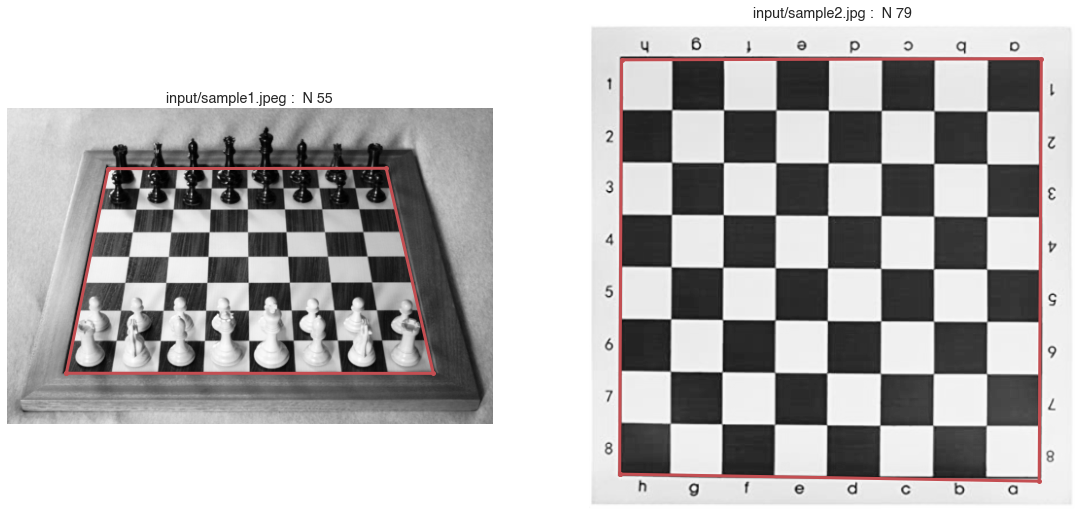

In [57]:
filenames = glob.glob('input/*')

fig = figure( figsize=(40, 40))
n = len(filenames)
row = n/col
if (n%col != 0):
    row += 1

for i in range(n):
    filename = filenames[i]
    print ("Processing %d/%d : %s" % (i+1,n,filename))

    img = loadImage(filename)
    M, ideal_grid, grid_next, grid_good, spts = findChessboard(img)

    # View
    if M is not None:
        M, _ = generateNewBestFit((ideal_grid+8)*32, grid_next, grid_good) # generate mapping for warping image
        img_warp = cv2.warpPerspective(img, M, (17*32, 17*32), flags=cv2.WARP_INVERSE_MAP)

        best_lines_x, best_lines_y = getBestLines(img_warp)
        xy_unwarp = getUnwarpedPoints(best_lines_x, best_lines_y, M)
        board_outline_unwarp = getBoardOutline(best_lines_x, best_lines_y, M)

        a=fig.add_subplot(row,col,i+1)
        
        axs = plt.axis()
        imshow(img, cmap='Greys_r');
        axs = plt.axis()
    #     plt.plot(spts[:,1],spts[:,0],'o')
#         plt.plot(grid_next[:,0].A, grid_next[:,1].A,'rs')
#         plt.plot(grid_next[grid_good,0].A, grid_next[grid_good,1].A,'rs', markersize=3)
#         plt.plot(xy_unwarp[:,0], xy_unwarp[:,1], 'r.',)
        print(board_outline_unwarp[:,0])
        print(board_outline_unwarp[:,1])
#         corner coordinates of the box
        corner_coords = list(zip(board_outline_unwarp[:4,0], board_outline_unwarp[:4,1]))
        print(corner_coords)
#         points order , 1. bottom left, bottom right, top right, top left, bottom left(repeated)
        plt.plot(board_outline_unwarp[:,0], board_outline_unwarp[:,1], 'ro-', markersize=5, linewidth=3)
        plt.axis(axs)
        plt.title("%s :  N %d" % (filename, np.sum(grid_good)))
        axis('off')
        print("    N good %d" % np.sum(grid_good))
        
    else:
        a=fig.add_subplot(row,col,i+1)
        imshow(img, cmap='Greys_r');
        plt.title("%s : Fail" % (filename))
        print("    Fail")

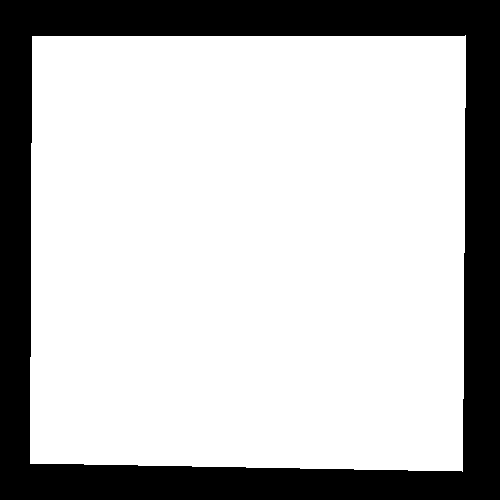

In [67]:
from PIL import Image, ImageDraw

polygon = corner_coords
maskIm = Image.new('L', (img.shape[1], img.shape[0]), 0)
ImageDraw.Draw(maskIm).polygon(polygon, outline=1, fill=1)
mask = numpy.array(maskIm)

# assemble new image (uint8: 0-255)
newImArray = numpy.empty(img.shape,dtype='uint8')

# colors (three first columns, RGB)
newImArray[:,:] = img[:,:]

# transparency (4th column)
newImArray[:,:] = mask*255

# back to Image from numpy
newIm = Image.fromarray(newImArray, "L")
newIm